In [1]:
# ✅ Importações e funções utilitárias
import numpy as np
from scipy.spatial import KDTree
import trimesh
import os
import matplotlib.pyplot as plt

def estimate_normals(points, k=30):
    tree = KDTree(points)
    normals = []
    for p in points:
        _, idx = tree.query(p, k=k)
        neighbors = points[idx]
        cov = np.cov(neighbors.T)
        eigvals, eigvecs = np.linalg.eigh(cov)
        normal = eigvecs[:, 0]
        normals.append(normal / np.linalg.norm(normal))
    return np.array(normals)

In [2]:
# ✅ Funções ICP ponto-a-plano e alinhamento
def best_fit_transform_point_to_plane(source, target, normals):
    A, b = [], []
    for p, q, n in zip(source, target, normals):
        cross = np.cross(p, n)
        A.append(np.hstack((cross, n)))
        b.append(np.dot(n, q - p))
    A = np.array(A)
    b = np.array(b).reshape(-1, 1)
    x, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    rot_vector = x[:3].flatten()
    t = x[3:].reshape(3, 1)
    angle = np.linalg.norm(rot_vector)
    if angle < 1e-12:
        R = np.eye(3)
    else:
        axis = rot_vector / angle
        K = np.array([[0, -axis[2], axis[1]],
                      [axis[2], 0, -axis[0]],
                      [-axis[1], axis[0], 0]])
        R = np.eye(3) + np.sin(angle) * K + (1 - np.cos(angle)) * (K @ K)
    return R, t

def ICP_point_to_plane(M, S, S_normals, init_pose=None, iterations=50, tolerance=1e-6, distance_threshold=1.0):
    if init_pose is None:
        R = np.eye(3)
        t = np.zeros((3, 1))
    else:
        R, t = init_pose
    prev_error = float('inf')
    for it in range(iterations):
        M_transformed = (R @ M.T).T + t.T
        tree = KDTree(S)
        distances, indices = tree.query(M_transformed)
        mask = distances < distance_threshold
        if np.sum(mask) < 3:
            break
        matched_S = S[indices][mask]
        matched_M = M_transformed[mask]
        matched_normals = S_normals[indices][mask]
        R_delta, t_delta = best_fit_transform_point_to_plane(matched_M, matched_S, matched_normals)
        R = R_delta @ R
        t = R_delta @ t + t_delta
        mean_error = np.mean(distances[mask])
        if abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error
    return R, t

In [3]:
# ✅ Alinhamento global com SVD
def best_fit_transform(A, B):
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B
    H = AA.T @ BB
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T
    t = centroid_B.T - R @ centroid_A.T
    return R, t.reshape(3,1)

In [5]:
# ✅ Carregar dados .obj e ground truth
kitti_dataset = '../dtLabs/KITTI-Sequence'
gt_path = '../dtLabs/ground_truth.npy'
point_clouds = []
for root, _, files in os.walk(kitti_dataset):
    for file in sorted(files):
        if file.endswith('.obj'):
            mesh = trimesh.load(os.path.join(root, file))
            point_clouds.append(np.asarray(mesh.vertices))
ground_truth = np.load(gt_path)

In [6]:
point_clouds[0]

array([[-9.110238, 18.638599,  0.909355],
       [-9.151207, 18.5732  ,  0.908344],
       [-9.206173, 18.536804,  0.908331],
       ...,
       [ 1.438176,  3.840138, -1.773556],
       [ 1.419202,  3.825716, -1.76457 ],
       [ 1.507196,  4.092375, -1.895561]])

In [7]:
ground_truth[0]

array([[ 1.000000e+00,  9.043680e-12,  2.326809e-11,  5.551115e-17],
       [ 9.043683e-12,  1.000000e+00,  2.392370e-10,  3.330669e-16],
       [ 2.326810e-11,  2.392370e-10,  9.999999e-01, -4.440892e-16],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

In [8]:
# ✅ Rodar ICP manual (point-to-plane) e estimar trajetória
trajectory = [np.eye(4)]
for i in range(len(point_clouds) - 1):
    A = point_clouds[i]
    B = point_clouds[i + 1]
    normals_B = estimate_normals(B, k=30)
    R, t = ICP_point_to_plane(A, B, normals_B, iterations=50, distance_threshold=1.0)
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = t.flatten()
    T_absolute = trajectory[-1] @ T
    trajectory.append(T_absolute)

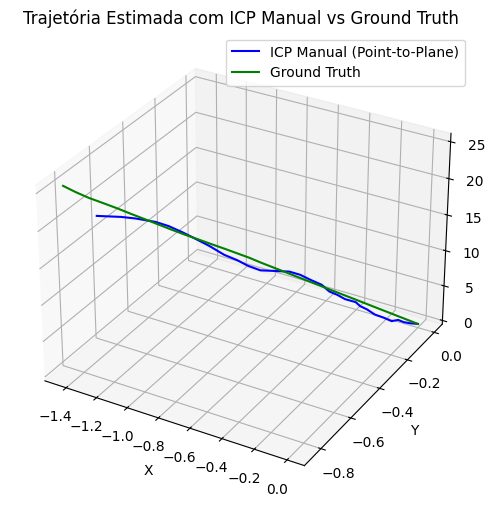

In [9]:
# ✅ Alinhar com ground truth e plotar resultado
icp_estimated = np.array([T[:3, 3] for T in trajectory])
gt_positions = np.array([gt[:3, 3] for gt in ground_truth[:len(icp_estimated)]])
R_init, t_init = best_fit_transform(icp_estimated, gt_positions)
icp_estimated_aligned = [(R_init @ p.reshape(3, 1) + t_init).flatten() for p in icp_estimated]
icp_estimated_aligned = np.array(icp_estimated_aligned)
offset = gt_positions[0] - icp_estimated_aligned[0]
icp_estimated_aligned += offset

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(icp_estimated_aligned[:, 0], icp_estimated_aligned[:, 1], icp_estimated_aligned[:, 2],
        label='ICP Manual (Point-to-Plane)', color='blue')
ax.plot(gt_positions[:, 0], gt_positions[:, 1], gt_positions[:, 2],
        label='Ground Truth', color='green')
ax.set_title('Trajetória Estimada com ICP Manual vs Ground Truth')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()